In [1]:
import cv2
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
import numpy as np
import sys
%matplotlib inline
from scipy import fftpack

In [2]:
def nb(point, points):
    points = np.array(points)
    dist = (points[:,0] - point[0])**2 + (points[:,1] - point[1])**2
    return np.argwhere(dist == dist.min())[0,0]

def FFT(s,t):
    fft = np.fft.fft(s)
    T = t[1] - t[0]  # sampling interval 
    N = s.size
    Amp = abs(fft)[0:N//2]
    Phase = np.angle(fft)[0:N//2]
    freq = np.linspace(0, 1 / T, N)[0:N//2]
   
    return Amp, Phase, freq

In [3]:
# name = 'tree2.png'
# name = 'tets2.png'
# name = 'test3.png'
# name = 'RND.png'
# name = 'test.png'

name = '9gag.png'

In [4]:
im = cv2.imread(name)
black = []
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        if list(im[i,j,:]) == [0,0,0]: #!= [255, 255, 255]:    #
            black.append([i,j])
point= black[0]          
line = [black[0]]
del black[0]

while len(black) > 0:
    i = nb(point, black)
    point = black[i]
    line.append(point)
    del black[i]

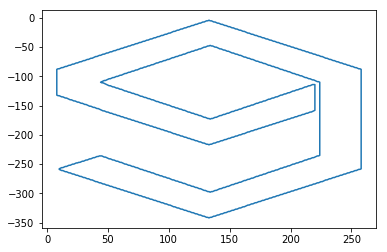

In [5]:
y = - abs(np.array(line)[:,0])[::-1]
x = abs(np.array(line)[:,1])[::-1]
plt.plot(x,y)

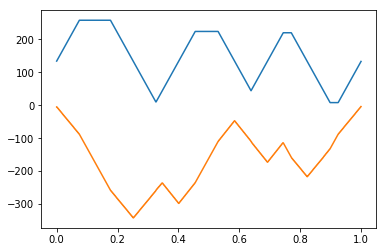

In [6]:
T = np.linspace(0,1, len(x))

plt.plot(T,x)
plt.plot(T,y)

In [7]:
Amp_x, Phase_x, freq_x, = FFT(x,T)
Amp_y, Phase_y, freq_y, = FFT(y,T)

a = np.transpose([Amp_x, Phase_x, freq_x, Amp_y, Phase_y, freq_y])
a = a[a[:,5].argsort()]
a = a[a[:,4].argsort(kind='mergesort')]
a = a[a[:,3].argsort(kind='mergesort')]
a = a[a[:,2].argsort(kind='mergesort')]
a = a[a[:,1].argsort(kind='mergesort')]
a = a[a[:,0].argsort(kind='mergesort')]

a = a[::-1, :]
Amp_x = a[:,0]
Phase_x = a[:,1]
freq_x = a[:,2]

Amp_y = a[:,3]
Phase_y = a[:,4]
freq_y = a[:,5]

In [8]:
harmonics = 831

recreation_x = np.zeros(len(T))
for i in range(harmonics):
    A = Amp_x[i]
    P = Phase_x[i]
    FF = A*np.cos(2*np.pi * freq_x[i] * T - P) / x.size
    recreation_x = recreation_x + FF
    
    
recreation_y = np.zeros(len(T))
for i in range(harmonics):
    A = Amp_y[i]
    P = Phase_y[i]
    FF = A*np.cos(2*np.pi * freq_y[i] * T - P)/ y.size
    recreation_y = recreation_y + FF

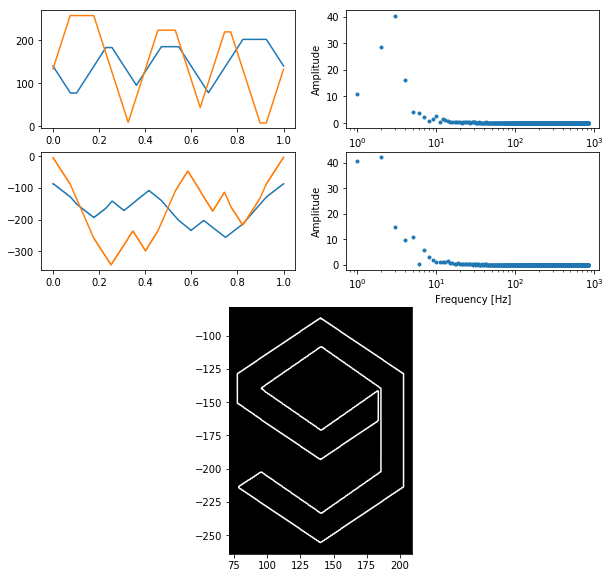

In [47]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplot(421)

plt.plot(T, recreation_x)
plt.plot(T,x)

plt.subplot(422)
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.semilogx(freq_x[1:], Amp_x[1:] / x.size, '.')  # 1 / N is a normalization factor

plt.subplot(423)

plt.plot(T, recreation_y)
plt.plot(T,y)

plt.subplot(424)
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.semilogx(freq_y[1:], Amp_y[1:] / y.size, '.')  # 1 / N is a normalization factor

ax = plt.subplot(212, aspect='equal')
ax.set_facecolor(('black'))
plt.plot(recreation_x, recreation_y,  'white')
plt.show()

In [27]:
def animini(H, shift  = 500000):
    Ta = np.linspace(0,np.pi, 10000)
    freq = 2* np.pi * freq_x

    xa = [0]
    ya = [0]
    xb = [0]
    yb = [0]

    for i in range(1, H+1):
        xa.append(Amp_x[i]* np.cos(freq[i]*Ta - Phase_x[i]) + xa[-1])
        ya.append(Amp_x[i]* np.sin(freq[i]*Ta - Phase_x[i]) + ya[-1])
        xb.append(Amp_y[i]* np.sin(freq[i]*Ta - Phase_y[i]) + xb[-1])
        yb.append(Amp_y[i]* np.cos(freq[i]*Ta - Phase_y[i]) + yb[-1])

    xa = xa[1:]
    ya = ya[1:]
    xb = xb[1:]
    yb = yb[1:]

    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111, aspect='equal', xlim = (-shift*2,shift*0.5), ylim = (-shift*0.5,shift*2) )

    linexx = [0 - shift]
    linexy = [0]
    for i in range(H):
        linexx.append(xa[i][0] - shift)
        linexy.append(ya[i][0])

    lineyx = [0]
    lineyy = [0 + shift]
    for i in range(H):
        lineyx.append(xb[i][0])
        lineyy.append(yb[i][0] + shift)


    Qx = [linexx[-1],linexx[-1]]
    Qy = [lineyy[-1], lineyy[-1]]
    
    
    l1, = ax.plot(linexx,linexy,'b')
    l2, = ax.plot(lineyx,lineyy,'b')
    l3, = ax.plot(linexx[-1], lineyy[-1], 'ro')
    l4, = ax.plot(Qx,Qy,'r')
    l5, = ax.plot([linexx[-1], linexx[-1]],[linexy[-1], lineyy[-1]], 'k', linewidth = 0.2)
    l6, = ax.plot([linexx[-1], lineyx[-1]],[lineyy[-1], lineyy[-1]], 'k', linewidth = 0.2)

    def inter(i):
        linexx = [0- shift]
        linexy = [0]
        for j in range(H):
            linexx.append(xa[j][i]- shift)
            linexy.append(ya[j][i])
        l1.set_data(linexx,linexy)

        lineyx = [0]
        lineyy = [0 + shift]
        for j in range(H):
            lineyx.append(xb[j][i])
            lineyy.append(yb[j][i]+shift)
        l2.set_data(lineyx,lineyy)
        l3.set_data(linexx[-1], lineyy[-1])
        Qx.append(linexx[-1])
        Qy.append(lineyy[-1])


        l4.set_data(Qx,Qy)
        l5.set_data([linexx[-1], linexx[-1]],[linexy[-1], lineyy[-1]])
        l6.set_data([linexx[-1], lineyx[-1]],[lineyy[-1], lineyy[-1]])
        return

    anim = animation.FuncAnimation(fig, inter, frames = len(Ta), interval = 1, repeat = False) 
    return anim

<IPython.core.display.Javascript object>


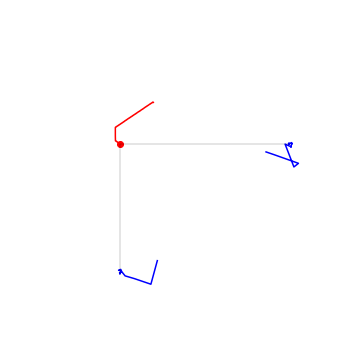

In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

anim = animini(831, 300000)
# anim.save('9gag')

<IPython.core.display.Javascript object>


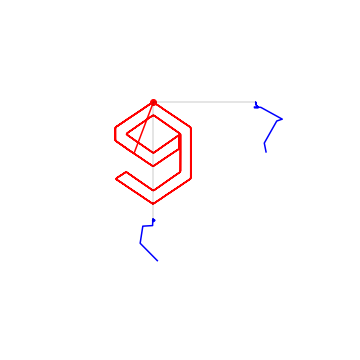

MovieWriter ffmpeg unavailable.


In [60]:
%matplotlib notebook

H = 831
shift = 300000

Ta = np.linspace(0,np.pi, 4000)
freq = 2* np.pi * freq_x

xa = [0]
ya = [0]
xb = [0]
yb = [0]

for i in range(1, H+1):
    xa.append(Amp_x[i]* np.cos(freq[i]*Ta - Phase_x[i]) + xa[-1])
    ya.append(Amp_x[i]* np.sin(freq[i]*Ta - Phase_x[i]) + ya[-1])
    xb.append(Amp_y[i]* np.sin(freq[i]*Ta - Phase_y[i]) + xb[-1])
    yb.append(Amp_y[i]* np.cos(freq[i]*Ta - Phase_y[i]) + yb[-1])

xa = xa[1:]
ya = ya[1:]
xb = xb[1:]
yb = yb[1:]

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111, aspect='equal', xlim = (-shift*2,shift*0.5), ylim = (-shift*0.5,shift*2) )
ax.set_facecolor(('black'))
plt.axis('off')


linexx = [0 - shift]
linexy = [0]
for i in range(H):
    linexx.append(xa[i][0] - shift)
    linexy.append(ya[i][0])

lineyx = [0]
lineyy = [0 + shift]
for i in range(H):
    lineyx.append(xb[i][0])
    lineyy.append(yb[i][0] + shift)


Qx = [linexx[-1],linexx[-1]]
Qy = [lineyy[-1], lineyy[-1]]

l1, = ax.plot(linexx,linexy,'b')
l2, = ax.plot(lineyx,lineyy,'b')
l3, = ax.plot(linexx[-1], lineyy[-1], 'ro')
l4, = ax.plot(Qx,Qy,'r')
l5, = ax.plot([linexx[-1], linexx[-1]],[linexy[-1], lineyy[-1]], 'k', linewidth = 0.2)
l6, = ax.plot([linexx[-1], lineyx[-1]],[lineyy[-1], lineyy[-1]], 'k', linewidth = 0.2)


def inter(I):
    i = I*4
    linexx = [0- shift]
    linexy = [0]
    for j in range(H):
        linexx.append(xa[j][i]- shift)
        linexy.append(ya[j][i])
    l1.set_data(linexx,linexy)

    lineyx = [0]
    lineyy = [0 + shift]
    for j in range(H):
        lineyx.append(xb[j][i])
        lineyy.append(yb[j][i]+shift)
    l2.set_data(lineyx,lineyy)
    l3.set_data(linexx[-1], lineyy[-1])
    Qx.append(linexx[-1])
    Qy.append(lineyy[-1])


    l4.set_data(Qx,Qy)
    l5.set_data([linexx[-1], linexx[-1]],[linexy[-1], lineyy[-1]])
    l6.set_data([linexx[-1], lineyx[-1]],[lineyy[-1], lineyy[-1]])
    return

anim = animation.FuncAnimation(fig, inter, frames = int(len(Ta)/4), interval = 0.1, repeat = False)

anim.save('9gag.gif', dpi = 50, fps= 15)